<a href="https://www.kaggle.com/code/javihm77/catboost-baseline-chapu-optuna?scriptVersionId=134200391" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Catboost Baseline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [2]:
import polars as pl
import gc
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math
from time import sleep
import pickle
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading Files

In [3]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [4]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ) ,
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")

]

In [5]:
dtypes = {"session_id": pl.Int64,
          "elapsed_time": pl.Int64,
          "event_name": pl.Categorical,
          "name": pl.Categorical,
          "level": pl.Int8,
          "page": pl.Float32,
          "room_coor_x": pl.Float32,
          "room_coor_y": pl.Float32,
          "screen_coor_x": pl.Float32,
          "screen_coor_y": pl.Float32,
          "hover_duration": pl.Float32,
          "fqid": pl.Categorical,
          "room_fqid": pl.Categorical,
          "fullscreen": pl.Int8,
          "hq": pl.Int8,
          "music": pl.Int8,
          "level_group": pl.Categorical
          }

In [6]:
pl.toggle_string_cache(True)

In [7]:
%%time

train = (pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',dtypes=dtypes)
                .drop(["fullscreen", "hq", "music"])
                .with_columns(columns)
        )

CPU times: user 32.3 s, sys: 13.4 s, total: 45.7 s
Wall time: 48.3 s


# Reducing training file

In [8]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df

In [9]:
# Reducing polar
train = reduce_memory_usage_pl(train, "train_subset")

Memory usage of dataframe train_subset is 3264.77 MB
Memory usage of dataframe train_subset became 1802.58 MB


In [10]:
df1 = train.filter(pl.col("level_group")=='0-4')
df2 = train.filter(pl.col("level_group")=='5-12')
df3 = train.filter(pl.col("level_group")=='13-22')
df1.shape,df2.shape,df3.shape

((3981005, 18), (8844238, 18), (13471703, 18))

In [11]:
df3.head(8)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff
i64,i16,i32,cat,cat,i8,f32,f32,f32,f32,f32,f32,cat,cat,cat,cat,cat,i32
20090312431273200,512,836732,"""navigate_click…","""undefined""",13,null,290.153564,-204.499359,null,null,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",0
20090312431273200,513,837245,"""navigate_click…","""undefined""",13,null,353.805603,-210.332062,21.0,0.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",513
20090312431273200,514,837779,"""navigate_click…","""undefined""",13,null,587.680054,-280.706238,108.0,44.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",534
20090312431273200,515,838446,"""navigate_click…","""undefined""",13,null,751.496887,-102.15329,43.0,124.0,null,null,"""toentry""","""tunic.capitol_…","""text_fqid_None…","""13-22""",667
20090312431273200,516,839629,"""map_hover""","""basic""",13,null,null,null,null,null,67.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1183
20090312431273200,517,840662,"""map_hover""","""basic""",13,null,null,null,null,null,983.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1033
20090312431273200,518,840780,"""map_hover""","""basic""",13,null,null,null,null,null,100.0,null,"""tunic.historic…","""tunic.capitol_…","""text_fqid_None…","""13-22""",118
20090312431273200,519,840830,"""map_hover""","""basic""",13,null,null,null,null,null,35.0,null,"""tunic.capitol_…","""tunic.capitol_…","""text_fqid_None…","""13-22""",50


In [12]:
#Delete train to liberate memory
del train
gc.collect()

30

# Feature Engineering

In [13]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [14]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],


        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}")for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          level_groups],

        *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],


    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")
                                              |(pl.col("fqid")=='logbook.page.bingo'))
                    .apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                                pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                                pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [15]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')

CPU times: user 8.11 s, sys: 651 ms, total: 8.76 s
Wall time: 4.62 s


In [16]:
%%time
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')

CPU times: user 21.6 s, sys: 780 ms, total: 22.3 s
Wall time: 12.1 s


In [17]:
%%time
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')

CPU times: user 35.2 s, sys: 920 ms, total: 36.1 s
Wall time: 18.9 s


In [18]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [19]:
df1.shape

(23562, 2344)

In [20]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    
    return train

In [21]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [22]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [23]:
df1.shape

(23562, 2350)

In [24]:
null1 = df1.isnull().sum().sort_values(ascending=False)/len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False)/len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False)/len(df3)

drop1 = list(null1[null1 > 0.7].index)
drop2 = list(null2[null2 > 0.7].index)
drop3 = list(null3[null3 > 0.7].index)

print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        #print(col)
        drop1.append(col)
        #sleep(0.1)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        #print(col)
        drop2.append(col)
        #sleep(0.1)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        #print(col)
        drop3.append(col)
        #sleep(0.1)

1225 1040 890


  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

In [25]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [26]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]

print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

We will train with 487 787 1042 features
We will train with 23562 users info


# Optuna Parameters optimization

In [27]:
def objective(trial,X,y):
    
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
    
    #cat_params = {
    #    "depth": trial.suggest_int("depth", 1, 9),
    #    "bootstrap_type": trial.suggest_categorical(
    #        "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
    #    ),
    #    'n_estimators': trial.suggest_int('n_estimators', 150, 750),
    #    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
    #    "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
    #    'random_seed': 42,
    #    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
    #    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    #    "used_ram_limit": "6gb",
    #    'eval_metric': 'AUC'
    #}
    
    cat_params = {
        "depth": trial.suggest_int("depth", 2, 9),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'n_estimators': trial.suggest_int('n_estimators', 100, 750),
        'learning_rate': 0.05,
        "objective": "Logloss",
        'random_seed': 42,
        "used_ram_limit": "6gb",
        'eval_metric': 'AUC'
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    gbm = CatBoostClassifier(**cat_params,verbose=False)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], early_stopping_rounds=60)

    preds = gbm.predict(valid_x)
    pred_labels = (preds > 0.62).astype('int')

    accuracy = accuracy_score(valid_y, pred_labels)
    
    return accuracy

In [28]:
# %%time

rf_best_params = []
studies = []

# ITERATE THRU QUESTIONS 1 THRU 18
for t in tqdm(range(1,19)): #1-19
        
    if t <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("")    
    print("*"*25)
    print(f'question{t}, with{len(FEATURES)}features')
    print('*'*25)
            
    # TRAIN DATA
    train_x = df[FEATURES]
    train_users = train_x.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
    
    # Wrap the objective inside a lambda and call objective inside it
    func = lambda trial: objective(trial, train_x, train_y['correct'])
    
    #Optuna 
    study = optuna.create_study(study_name=f"catboost_{t}",direction="maximize")
    study.optimize(func, n_trials=10, timeout=500)
    
    print(f'--- Model: {grp}_{t}')
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    print('Best value:', study.best_value)
    
    rf_best_params.append(study.best_trial.params)
    studies.append(study)
        
print("-"*80)


  0%|          | 0/18 [00:00<?, ?it/s]

[I 2023-06-20 05:13:05,258] A new study created in memory with name: catboost_1



*************************
question1, with487features
*************************


[I 2023-06-20 05:13:37,119] Trial 0 finished with value: 0.7548450983165936 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 468}. Best is trial 0 with value: 0.7548450983165936.
[I 2023-06-20 05:13:53,777] Trial 1 finished with value: 0.755693874664026 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 395, 'bagging_temperature': 1.2531098657645734}. Best is trial 1 with value: 0.755693874664026.
[I 2023-06-20 05:14:49,916] Trial 2 finished with value: 0.7541377846937332 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 169}. Best is trial 1 with value: 0.755693874664026.
[I 2023-06-20 05:15:17,527] Trial 3 finished with value: 0.7576743528080351 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 448}. Best is trial 3 with value: 0.7576743528080351.
[I 2023-06-20 05:15:47,103] Trial 4 finished with value: 0.7464987975668411 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 409,

--- Model: 0-4_1
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 448}
Best value: 0.7576743528080351

*************************
question2, with487features
*************************


[I 2023-06-20 05:18:47,529] Trial 0 finished with value: 0.9776488895176121 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 264, 'subsample': 0.8537955620607903}. Best is trial 0 with value: 0.9776488895176121.
[I 2023-06-20 05:18:51,247] Trial 1 finished with value: 0.9776488895176121 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 629, 'bagging_temperature': 1.7060085687088256}. Best is trial 0 with value: 0.9776488895176121.
[I 2023-06-20 05:19:00,543] Trial 2 finished with value: 0.9790635167633328 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 206, 'bagging_temperature': 7.3249564935698475}. Best is trial 2 with value: 0.9790635167633328.
[I 2023-06-20 05:19:23,877] Trial 3 finished with value: 0.9790635167633328 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 522}. Best is trial 2 with value: 0.9790635167633328.
[I 2023-06-20 05:19:28,053] Trial 4 finished with value: 0.979063

--- Model: 0-4_2
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 385, 'bagging_temperature': 0.6251498539600009}
Best value: 0.981043994907342

*************************
question3, with487features
*************************


[I 2023-06-20 05:21:57,404] Trial 0 finished with value: 0.9366246993917103 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 511, 'bagging_temperature': 5.863646595844228}. Best is trial 0 with value: 0.9366246993917103.
[I 2023-06-20 05:22:01,072] Trial 1 finished with value: 0.9325222803791201 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 379, 'bagging_temperature': 9.591767844731734}. Best is trial 0 with value: 0.9366246993917103.
[I 2023-06-20 05:22:33,969] Trial 2 finished with value: 0.9328052058282642 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 174, 'bagging_temperature': 2.740591294055321}. Best is trial 0 with value: 0.9366246993917103.
[I 2023-06-20 05:22:41,509] Trial 3 finished with value: 0.9339369076248408 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 185, 'subsample': 0.7247042058398407}. Best is trial 0 with value: 0.9366246993917103.
[I 2023-06-20 05:22:

--- Model: 0-4_3
Number of finished trials: 10
Best trial: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 183, 'subsample': 0.46907643034227464}
Best value: 0.937897863912859

*************************
question4, with787features
*************************


[I 2023-06-20 05:27:11,314] Trial 0 finished with value: 0.8204838025180365 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 491, 'subsample': 0.7924431762824841}. Best is trial 0 with value: 0.8204838025180365.
[I 2023-06-20 05:28:01,821] Trial 1 finished with value: 0.8192106379968879 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 679, 'bagging_temperature': 0.2602331612249664}. Best is trial 0 with value: 0.8204838025180365.
[I 2023-06-20 05:29:16,987] Trial 2 finished with value: 0.819493563446032 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 573}. Best is trial 0 with value: 0.8204838025180365.
[I 2023-06-20 05:30:04,534] Trial 3 finished with value: 0.8117131135945679 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 506}. Best is trial 0 with value: 0.8204838025180365.
[I 2023-06-20 05:30:27,582] Trial 4 finished with value: 0.8144009053614373 and parameters: {'depth': 5, 'bootstra

--- Model: 5-12_4
Number of finished trials: 10
Best trial: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 434}
Best value: 0.8221813552129014

*************************
question5, with787features
*************************


[I 2023-06-20 05:34:30,040] Trial 0 finished with value: 0.6527090111755552 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 750}. Best is trial 0 with value: 0.6527090111755552.
[I 2023-06-20 05:35:36,990] Trial 1 finished with value: 0.6501626821332579 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 630}. Best is trial 0 with value: 0.6527090111755552.
[I 2023-06-20 05:38:08,794] Trial 2 finished with value: 0.6604894610270193 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 673}. Best is trial 2 with value: 0.6604894610270193.
[I 2023-06-20 05:38:29,399] Trial 3 finished with value: 0.6596406846795869 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 311, 'bagging_temperature': 1.723345628731332}. Best is trial 2 with value: 0.6604894610270193.
[I 2023-06-20 05:39:08,658] Trial 4 finished with value: 0.6619040882727402 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 326}. B

--- Model: 5-12_5
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 326}
Best value: 0.6619040882727402

*************************
question6, with787features
*************************


[I 2023-06-20 05:42:55,015] Trial 0 finished with value: 0.7887961522138917 and parameters: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 247, 'subsample': 0.7709113440517232}. Best is trial 0 with value: 0.7887961522138917.
[I 2023-06-20 05:44:17,234] Trial 1 finished with value: 0.7991229311076531 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 265}. Best is trial 1 with value: 0.7991229311076531.
[I 2023-06-20 05:45:17,405] Trial 2 finished with value: 0.7863912858961664 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 683, 'bagging_temperature': 1.439304581320332}. Best is trial 1 with value: 0.7991229311076531.
[I 2023-06-20 05:45:33,657] Trial 3 finished with value: 0.783844956853869 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 382, 'subsample': 0.6376546169229889}. Best is trial 1 with value: 0.7991229311076531.
[I 2023-06-20 05:47:10,786] Trial 4 finished with value: 0.782005941434432 a

--- Model: 5-12_6
Number of finished trials: 10
Best trial: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 265}
Best value: 0.7991229311076531

*************************
question7, with787features
*************************


[I 2023-06-20 05:51:42,327] Trial 0 finished with value: 0.7531475456217287 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 634, 'bagging_temperature': 4.4432939339770225}. Best is trial 0 with value: 0.7531475456217287.
[I 2023-06-20 05:52:06,353] Trial 1 finished with value: 0.7532890083463007 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 388, 'bagging_temperature': 7.0195482555060345}. Best is trial 1 with value: 0.7532890083463007.
[I 2023-06-20 05:53:19,585] Trial 2 finished with value: 0.7394256613382374 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 379}. Best is trial 1 with value: 0.7532890083463007.
[I 2023-06-20 05:54:09,460] Trial 3 finished with value: 0.7394256613382374 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 344, 'bagging_temperature': 1.3726049483497549}. Best is trial 1 with value: 0.7532890083463007.
[I 2023-06-20 05:54:52,403] Trial 4 finished with value:

--- Model: 5-12_7
Number of finished trials: 10
Best trial: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 403, 'bagging_temperature': 3.89837324896958}
Best value: 0.7548450983165936

*************************
question8, with787features
*************************


[I 2023-06-20 06:00:43,020] Trial 0 finished with value: 0.624133540811996 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 279, 'subsample': 0.5031536748434191}. Best is trial 0 with value: 0.624133540811996.
[I 2023-06-20 06:01:15,942] Trial 1 finished with value: 0.6360164096760503 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 409}. Best is trial 1 with value: 0.6360164096760503.
[I 2023-06-20 06:02:14,515] Trial 2 finished with value: 0.6254067053331447 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 169, 'bagging_temperature': 8.01766645457134}. Best is trial 1 with value: 0.6360164096760503.
[I 2023-06-20 06:02:31,054] Trial 3 finished with value: 0.6244164662611402 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 437, 'subsample': 0.20502044115007612}. Best is trial 1 with value: 0.6360164096760503.
[I 2023-06-20 06:04:10,727] Trial 4 finished with value: 0.6186164945536851 a

--- Model: 5-12_8
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 409}
Best value: 0.6360164096760503

*************************
question9, with787features
*************************


[I 2023-06-20 06:07:32,728] Trial 0 finished with value: 0.749893902956571 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 466, 'subsample': 0.7273515063255694}. Best is trial 0 with value: 0.749893902956571.
[I 2023-06-20 06:07:40,546] Trial 1 finished with value: 0.740557363134814 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 342, 'bagging_temperature': 6.163919190620696}. Best is trial 0 with value: 0.749893902956571.
[I 2023-06-20 06:11:34,945] Trial 2 finished with value: 0.7459329466685528 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 537, 'bagging_temperature': 6.062909048875998}. Best is trial 0 with value: 0.749893902956571.
[I 2023-06-20 06:12:22,433] Trial 3 finished with value: 0.7554109492148818 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 681, 'subsample': 0.690115213751611}. Best is trial 3 with value: 0.7554109492148818.
[I 2023-06-20 06:12:58,956] Trial 

--- Model: 5-12_9
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 407, 'subsample': 0.7216799062167978}
Best value: 0.7568255764606027

*************************
question10, with787features
*************************


[I 2023-06-20 06:17:19,153] Trial 0 finished with value: 0.6256896307822889 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 502, 'subsample': 0.2945548897219696}. Best is trial 0 with value: 0.6256896307822889.
[I 2023-06-20 06:17:49,059] Trial 1 finished with value: 0.6399773659640685 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 309}. Best is trial 1 with value: 0.6399773659640685.
[I 2023-06-20 06:18:16,438] Trial 2 finished with value: 0.6348847078794737 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 682, 'subsample': 0.5925662115517017}. Best is trial 1 with value: 0.6399773659640685.
[I 2023-06-20 06:18:52,638] Trial 3 finished with value: 0.6330456924600368 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 178, 'subsample': 0.7169180661442409}. Best is trial 1 with value: 0.6399773659640685.
[I 2023-06-20 06:19:23,320] Trial 4 finished with value: 0.6288018107228746 and par

--- Model: 5-12_10
Number of finished trials: 9
Best trial: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 309}
Best value: 0.6399773659640685

*************************
question11, with787features
*************************


[I 2023-06-20 06:24:55,237] Trial 0 finished with value: 0.6593577592304428 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 490}. Best is trial 0 with value: 0.6593577592304428.
[I 2023-06-20 06:25:17,049] Trial 1 finished with value: 0.6624699391710285 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 343, 'bagging_temperature': 3.509249976760598}. Best is trial 1 with value: 0.6624699391710285.
[I 2023-06-20 06:25:55,885] Trial 2 finished with value: 0.6679869854293393 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 490, 'subsample': 0.4699859256993686}. Best is trial 2 with value: 0.6679869854293393.
[I 2023-06-20 06:26:19,390] Trial 3 finished with value: 0.6725137926156458 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 622}. Best is trial 3 with value: 0.6725137926156458.
[I 2023-06-20 06:26:58,933] Trial 4 finished with value: 0.6682699108784835 and parameters: {'depth': 6, 'bootstra

--- Model: 5-12_11
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 622}
Best value: 0.6725137926156458

*************************
question12, with787features
*************************


[I 2023-06-20 06:32:03,447] Trial 0 finished with value: 0.8695713679445466 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 251}. Best is trial 0 with value: 0.8695713679445466.
[I 2023-06-20 06:32:18,508] Trial 1 finished with value: 0.86094214174565 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 391, 'subsample': 0.8874498868911488}. Best is trial 0 with value: 0.8695713679445466.
[I 2023-06-20 06:32:40,813] Trial 2 finished with value: 0.8634884707879473 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 278, 'bagging_temperature': 6.685502641971447}. Best is trial 0 with value: 0.8695713679445466.
[I 2023-06-20 06:33:22,524] Trial 3 finished with value: 0.8603762908473617 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 333, 'bagging_temperature': 7.579031680868306}. Best is trial 0 with value: 0.8695713679445466.
[I 2023-06-20 06:33:39,089] Trial 4 finished with value: 0.8575470363

--- Model: 5-12_12
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 251}
Best value: 0.8695713679445466

*************************
question13, with787features
*************************


[I 2023-06-20 06:37:24,202] Trial 0 finished with value: 0.738718347715377 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 445, 'subsample': 0.39411794742586936}. Best is trial 0 with value: 0.738718347715377.
[I 2023-06-20 06:38:47,634] Trial 1 finished with value: 0.7455085584948367 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 444, 'subsample': 0.8687873489192652}. Best is trial 1 with value: 0.7455085584948367.
[I 2023-06-20 06:41:30,086] Trial 2 finished with value: 0.7382939595416608 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 404}. Best is trial 1 with value: 0.7455085584948367.
[I 2023-06-20 06:41:53,349] Trial 3 finished with value: 0.7429622294525392 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 617, 'subsample': 0.34448984774882796}. Best is trial 1 with value: 0.7455085584948367.
[I 2023-06-20 06:42:19,894] Trial 4 finished with value: 0.7395671240628094 and par

--- Model: 5-12_13
Number of finished trials: 7
Best trial: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 444, 'subsample': 0.8687873489192652}
Best value: 0.7455085584948367

*************************
question14, with1042features
*************************


[I 2023-06-20 06:46:04,172] Trial 0 finished with value: 0.7326354505587778 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 360, 'subsample': 0.9427873374797915}. Best is trial 0 with value: 0.7326354505587778.
[I 2023-06-20 06:46:28,000] Trial 1 finished with value: 0.7224501343895884 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 118, 'bagging_temperature': 9.820784507892755}. Best is trial 0 with value: 0.7326354505587778.
[I 2023-06-20 06:46:48,499] Trial 2 finished with value: 0.729240345169048 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 330, 'bagging_temperature': 8.802276656391058}. Best is trial 0 with value: 0.7326354505587778.
[I 2023-06-20 06:47:55,290] Trial 3 finished with value: 0.7276842551987551 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 428, 'subsample': 0.547909885838888}. Best is trial 0 with value: 0.7326354505587778.
[I 2023-06-20 06:49:11,193] Tr

--- Model: 13-22_14
Number of finished trials: 10
Best trial: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 462}
Best value: 0.7388598104399491

*************************
question15, with1042features
*************************


[I 2023-06-20 06:53:28,945] Trial 0 finished with value: 0.6563870420144292 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 247}. Best is trial 0 with value: 0.6563870420144292.
[I 2023-06-20 06:55:05,592] Trial 1 finished with value: 0.6432310086292262 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 231, 'subsample': 0.9068048406047345}. Best is trial 0 with value: 0.6563870420144292.
[I 2023-06-20 06:58:09,410] Trial 2 finished with value: 0.6491724430612533 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 713, 'bagging_temperature': 8.79870278920203}. Best is trial 0 with value: 0.6563870420144292.
[I 2023-06-20 06:59:12,340] Trial 3 finished with value: 0.6607723864761635 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 624, 'bagging_temperature': 1.004205273224421}. Best is trial 3 with value: 0.6607723864761635.
[I 2023-06-20 07:00:19,109] Trial 4 finished with value: 0.658791908

--- Model: 13-22_15
Number of finished trials: 6
Best trial: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 624, 'bagging_temperature': 1.004205273224421}
Best value: 0.6607723864761635

*************************
question16, with1042features
*************************


[I 2023-06-20 07:01:20,336] Trial 0 finished with value: 0.7404159004102419 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 384, 'subsample': 0.8864138264689996}. Best is trial 0 with value: 0.7404159004102419.
[I 2023-06-20 07:01:40,720] Trial 1 finished with value: 0.7300891215164804 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 545, 'subsample': 0.5117857483521}. Best is trial 0 with value: 0.7404159004102419.
[I 2023-06-20 07:02:10,176] Trial 2 finished with value: 0.7371622577450841 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 302}. Best is trial 0 with value: 0.7404159004102419.
[I 2023-06-20 07:02:42,091] Trial 3 finished with value: 0.744235393973688 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 386, 'bagging_temperature': 9.03886770298479}. Best is trial 3 with value: 0.744235393973688.
[I 2023-06-20 07:03:03,716] Trial 4 finished with value: 0.7360305559485075 and p

--- Model: 13-22_16
Number of finished trials: 10
Best trial: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 386, 'bagging_temperature': 9.03886770298479}
Best value: 0.744235393973688

*************************
question17, with1042features
*************************


[I 2023-06-20 07:07:36,107] Trial 0 finished with value: 0.6838308105814118 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 364}. Best is trial 0 with value: 0.6838308105814118.
[I 2023-06-20 07:08:10,337] Trial 1 finished with value: 0.6967039185174706 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 641, 'subsample': 0.16744592440090833}. Best is trial 1 with value: 0.6967039185174706.
[I 2023-06-20 07:08:24,987] Trial 2 finished with value: 0.6916112604328759 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 366, 'bagging_temperature': 8.152492736637564}. Best is trial 1 with value: 0.6967039185174706.
[I 2023-06-20 07:09:11,477] Trial 3 finished with value: 0.6900551704625831 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 728, 'bagging_temperature': 6.521694388121291}. Best is trial 1 with value: 0.6967039185174706.
[I 2023-06-20 07:10:02,561] Trial 4 finished with value: 0.6879332

--- Model: 13-22_17
Number of finished trials: 9
Best trial: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 641, 'subsample': 0.16744592440090833}
Best value: 0.6967039185174706

*************************
question18, with1042features
*************************


[I 2023-06-20 07:16:57,476] Trial 0 finished with value: 0.9480831800820484 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 675, 'bagging_temperature': 3.9510087221048273}. Best is trial 0 with value: 0.9480831800820484.
[I 2023-06-20 07:18:47,814] Trial 1 finished with value: 0.9494978073277691 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 262, 'subsample': 0.5049499503782849}. Best is trial 1 with value: 0.9494978073277691.
[I 2023-06-20 07:19:41,701] Trial 2 finished with value: 0.9486490309803367 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 543}. Best is trial 1 with value: 0.9494978073277691.
[I 2023-06-20 07:21:33,749] Trial 3 finished with value: 0.9523270618192107 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 275, 'bagging_temperature': 0.35102418392619517}. Best is trial 3 with value: 0.9523270618192107.
[I 2023-06-20 07:21:51,305] Trial 4 finished with value: 0.95147

--- Model: 13-22_18
Number of finished trials: 9
Best trial: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 438, 'bagging_temperature': 2.3174296520656856}
Best value: 0.9538831517895034
--------------------------------------------------------------------------------


In [29]:
# Historic
plot_optimization_history(studies[15])

In [30]:
# Importance
optuna.visualization.plot_param_importances(studies[15])

In [31]:
#optuna.visualization.plot_slice(studies[15], params=['n_estimators','learning_rate', 'min_data_in_leaf'])

In [32]:
#optuna.visualization.plot_slice(studies[15], params=['depth','colsample_bylevel', 'bootstrap_type'])

# Printing best parameters for the 18 models

In [33]:
#Print all params
for i in range(len(rf_best_params)):    
    print("Model: ",i+1)
    print(rf_best_params[i])

Model:  1
{'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 448}
Model:  2
{'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 385, 'bagging_temperature': 0.6251498539600009}
Model:  3
{'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 183, 'subsample': 0.46907643034227464}
Model:  4
{'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 434}
Model:  5
{'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 326}
Model:  6
{'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 265}
Model:  7
{'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 403, 'bagging_temperature': 3.89837324896958}
Model:  8
{'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 409}
Model:  9
{'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 407, 'subsample': 0.7216799062167978}
Model:  10
{'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 309}
Model:  11
{'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 622}
Model:  12
{'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 2

In [34]:
#Save best params using Picke

f_save = open('best_params.pkl', 'wb')
pickle.dump(rf_best_params, f_save)
f_save.close()

In [35]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

In [36]:
# Delete from memory unused variables


# Train CatBoost models

In [37]:
feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)]
gkf = GroupKFold(n_splits=2)
oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

In [38]:
best_params = pickle.load(open("best_params.pkl", "rb"))

In [39]:
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("-"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('-'*25)
    
    feature_importance_df = pd.DataFrame()
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]

        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])

        model = CatBoostClassifier(**best_params[q-1],verbose=False)
        model = model.fit(train_pool, eval_set=valid_pool)

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(fold, q)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
        
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))
results = [[np.concatenate(_) for _ in _] for _ in results]

  0%|          | 0/18 [00:00<?, ?it/s]

-------------------------
question1, with487features
-------------------------


,mean
feature,
chap1_finale_c_ET_sum_,2.233917
tunic.capitol_0.hall_ET_max_,1.645477
4_ET_sum_,1.614428
3tunic.historicalsociety.collection_level_room_count,1.577013
tunic.capitol_0.hall_ET_sum_,1.467947
chap1_finale_c_ET_mean_,1.446315
tunic.historicalsociety.collection.cs_ET_mean_,1.399718
checkpoint_ET_mean_,1.386384
tunic.historicalsociety.entry.groupconvo_ET_mean_,1.374657


-------------------------
question2, with487features
-------------------------


,mean
feature,
tunic.historicalsociety.collection.gramps.found_ET_min_,2.811341
object_click_event_name_counts,1.855526
tunic.capitol_0.hall_ET_sum_,1.646615
person_click_ET_min_,1.384506
checkpoint_ET_mean_,1.358770
tunic.capitol_0.hall_ET_max_,1.178290
chap1_finale_c_ET_sum_,1.137232
basic_name_counts,1.129439
tunic.historicalsociety.entry.groupconvo_ET_mean_,1.062614


-------------------------
question3, with487features
-------------------------


,mean
feature,
basic_name_counts,5.808539
checkpoint_ET_mean_,4.488551
checkpoint_ET_min_,3.439871
tunic.capitol_0.hall_ET_sum_,2.514960
elapsed_time_diff_max_,2.361867
tunic.capitol_0.hall_ET_max_,2.216797
tunic.historicalsociety.collection_room_fqid_counts,2.004231
object_click_event_name_counts,1.952806
chap1_finale_c_ET_max_,1.728107


-------------------------
question4, with787features
-------------------------


,mean
feature,
tunic.humanecology.frontdesk.worker.intro_ET_mean_,3.149759
tunic.library.frontdesk.worker.wells_ET_mean_,2.931567
tunic.historicalsociety.frontdesk_room_fqid_counts,2.927565
5-12_LEVEL_group_count,2.632181
tunic.library.frontdesk.worker.wells_ET_sum_,2.371661
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,1.863262
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_sum_,1.730419
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_mean_,1.452748
tunic.library.frontdesk.worker.hello_ET_sum_,1.317329


-------------------------
question5, with787features
-------------------------


,mean
feature,
tunic.humanecology.frontdesk.worker.intro_ET_mean_,2.186782
5-12_LEVEL_group_count,1.557977
11_LEVEL_count,1.477180
tunic.humanecology.frontdesk.worker.intro_ET_sum_,1.367509
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,1.214480
basic_name_counts,1.179275
session_number_,1.150857
tunic.humanecology.frontdesk.worker.intro_ET_min_,0.977604
observation_click_ET_max_,0.870116


-------------------------
question6, with787features
-------------------------


,mean
feature,
session_number_,1.175219
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.967946
basic_name_counts,0.947747
logbook.page.bingo_ET_std_,0.922993
businesscards.card_bingo.bingo_fqid_counts,0.912355
11_LEVEL_count,0.907838
tunic.historicalsociety.frontdesk.archivist.have_glass_ET_std_,0.826003
map_click_event_name_counts,0.783899
undefined_name_counts,0.770267


-------------------------
question7, with787features
-------------------------


,mean
feature,
basic_name_counts,1.135366
map_click_event_name_counts,1.060455
journals.pic_0.next_ET_sum_,0.727481
11_LEVEL_count,0.642626
observation_click_ET_max_,0.609378
reader_ET_sum_,0.528749
reader_fqid_counts,0.501898
worker_fqid_counts,0.499251
9tunic.library.microfiche_level_room_count,0.460938


-------------------------
question8, with787features
-------------------------


,mean
feature,
object_click_event_name_counts,1.411735
basic_name_counts,1.035964
tunic.humanecology.frontdesk.worker.intro_ET_sum_,0.954406
text_fqid_unique_,0.874415
11_LEVEL_count,0.824208
tunic.library.frontdesk.worker.hello_ET_mean_,0.781950
5-12_LEVEL_group_count,0.752738
journals.pic_2.next_ET_sum_,0.729742
tunic.historicalsociety.frontdesk_room_fqid_counts,0.714333


-------------------------
question9, with787features
-------------------------


,mean
feature,
logbook.page.bingo_ET_max_,1.320098
observation_click_ET_mean_,1.009181
11_LEVEL_count,1.009022
5-12_LEVEL_group_count,0.968937
notebook_click_ET_max_,0.875530
reader_fqid_counts,0.816855
tunic.historicalsociety.closet_dirty.gramps.news_ET_sum_,0.784013
session_number_,0.755163
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.732816


-------------------------
question10, with787features
-------------------------


,mean
feature,
11_LEVEL_count,2.979749
basic_name_counts,1.911657
5-12_LEVEL_group_count,1.268057
object_click_event_name_counts,1.136269
tunic.historicalsociety.stacks_ET_sum_,1.020229
tunic.historicalsociety.closet_dirty.gramps.news_ET_mean_,1.007978
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.969129
session_number_,0.856999
tunic.historicalsociety.frontdesk_room_fqid_counts,0.852078


-------------------------
question11, with787features
-------------------------


,mean
feature,
5-12_LEVEL_group_count,2.260936
tostacks_ET_sum_,1.005502
11_LEVEL_count,0.930491
navigate_click_event_name_counts,0.910964
session_number_,0.894862
room_coor_y_mean_,0.828217
reader_fqid_counts,0.797919
basic_name_counts,0.697155
tunic.historicalsociety.frontdesk_room_fqid_counts,0.694310


-------------------------
question12, with787features
-------------------------


,mean
feature,
tunic.historicalsociety.frontdesk_room_fqid_counts,1.511385
basic_name_counts,1.296224
journals_ET_sum_,0.980208
tostacks_ET_sum_,0.909796
tunic.humanecology.frontdesk.worker.intro_ET_sum_,0.907530
reader_ET_min_,0.823551
hover_duration_mean_,0.796903
journals.pic_2.next_ET_max_,0.780321
9_LEVEL_count,0.737450


-------------------------
question13, with787features
-------------------------


,mean
feature,
object_click_event_name_counts,2.217403
businesscards_fqid_counts,1.427434
journals_bingo_duration,1.343574
tunic.historicalsociety.stacks.journals.pic_2.bingo_ET_max_,1.201489
reader_bingo_duration,0.829789
tunic.drycleaner.frontdesk.logbook.page.bingo_ET_mean_,0.783001
reader.paper1.next_ET_sum_,0.749904
object_click_ET_sum_,0.731134
tunic.library.frontdesk.worker.droppedbadge_text_fqid_counts,0.716902


-------------------------
question14, with1042features
-------------------------


,mean
feature,
20_LEVEL_count,1.366365
tunic.flaghouse.entry.colorbook_ET_min_,0.855597
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_mean_,0.712210
tunic.historicalsociety.entry.boss.flag_ET_min_,0.656094
tracks_ET_sum_,0.642283
13-22_LEVEL_group_count,0.637045
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.620480
tracks_fqid_counts,0.616011
directory.closeup.archivist_ET_sum_,0.606901


-------------------------
question15, with1042features
-------------------------


,mean
feature,
13-22_LEVEL_group_count,0.892958
tunic.flaghouse.entry.colorbook_ET_mean_,0.891926
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.751564
tunic.flaghouse.entry.colorbook_ET_sum_,0.713730
tunic.historicalsociety.entry.boss.flag_ET_min_,0.708250
tunic.flaghouse.entry.colorbook_ET_min_,0.701238
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,0.683758
groupconvo_flag_ET_sum_,0.645342
directory.closeup.archivist_ET_mean_,0.638918


-------------------------
question16, with1042features
-------------------------


,mean
feature,
tunic.wildlife.center_room_fqid_counts,0.899327
19tunic.wildlife.center_level_room_count,0.579313
13-22_LEVEL_group_count,0.573861
tobasement_ET_std_,0.546257
journals_flag.hub.topics_ET_std_,0.501885
tunic.wildlife.center.wells.nodeer_recap_ET_std_,0.499904
basic_name_counts,0.487982
room_coor_x_mean_,0.475344
tunic.wildlife_ET_min_,0.466338


-------------------------
question17, with1042features
-------------------------


,mean
feature,
journals_flag.hub.topics_ET_mean_,0.619079
tunic.library_ET_max_,0.490007
journals_flag.hub.topics_ET_sum_,0.484383
journals_flag.pic_1.next_ET_max_,0.474866
tunic.historicalsociety.entry.directory.closeup.archivist_ET_min_,0.447829
22_ET_sum_,0.437099
tunic.historicalsociety.frontdesk.key_ET_min_,0.428693
tunic.flaghouse.entry.colorbook_ET_sum_,0.428281
journals_flag.pic_0.bingo_ET_min_,0.416555


-------------------------
question18, with1042features
-------------------------


,mean
feature,
20_LEVEL_count,1.075397
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.974287
tunic.historicalsociety.entry.groupconvo_flag_ET_mean_,0.930268
tunic.flaghouse.entry.flag_girl.symbol_recap_text_fqid_counts,0.735624
map_click_ET_sum_,0.729929
tunic.historicalsociety.entry.directory.closeup.archivist_ET_min_,0.708438
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts,0.694308
22_ET_sum_,0.618044
tunic.historicalsociety.cage_room_fqid_counts,0.615397


In [40]:
for (fold,q), model in models.items():
    model.save_model(f'fold{fold}_q{q}.cbm')

In [41]:
true = pd.DataFrame(np.stack([_[0] for _ in results]).T)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

In [42]:
scores = []; thresholds = []
best_socre = 0; best_threshold = 0

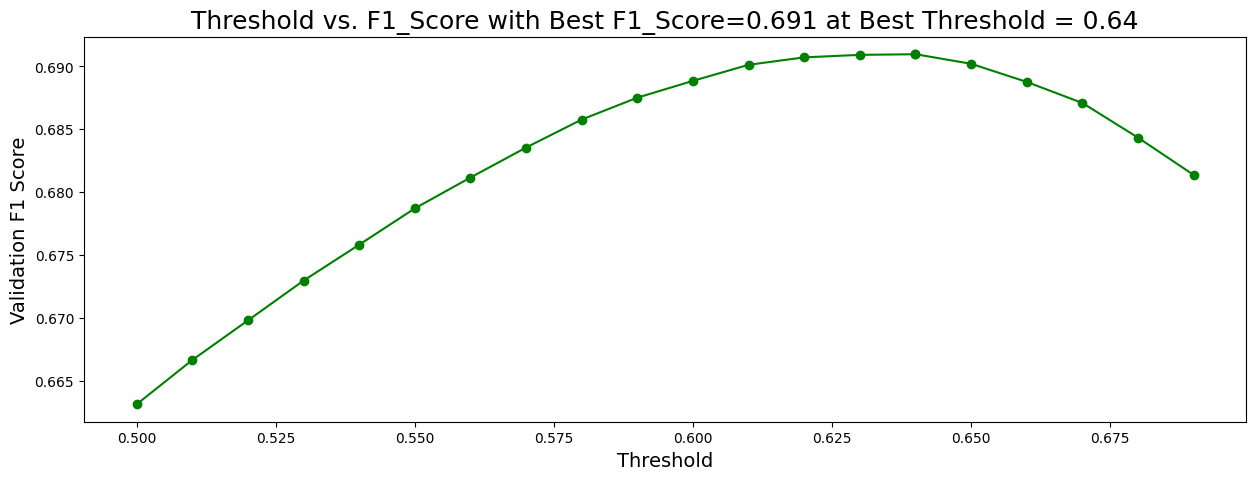

When using optimal threshold = 0.64...
Q1: F1 = 0.6657342456573145
Q2: F1 = 0.5023800947521235
Q3: F1 = 0.5182128748494728
Q4: F1 = 0.6688711327553195
Q5: F1 = 0.6105358627982104
Q6: F1 = 0.6331944379530093
Q7: F1 = 0.6185546221621804
Q8: F1 = 0.5448356372580017
Q9: F1 = 0.6249283430882
Q10: F1 = 0.5515872417415365
Q11: F1 = 0.6036143375775254
Q12: F1 = 0.5074919973500727
Q13: F1 = 0.44287918216162414
Q14: F1 = 0.6345247810149324
Q15: F1 = 0.5705511403324525
Q16: F1 = 0.49716554661031565
Q17: F1 = 0.5495851312078095
Q18: F1 = 0.5031693334910924
==> Overall F1 = 0.690972107555042
s


In [43]:
for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(15, 5))
plt.plot(thresholds, scores, '-o', color='green')
plt.scatter([best_threshold], [best_socre], color='green')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k+1}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

# Submission Jo Wilder

In [44]:
import jo_wilder_310 as jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [45]:
models_list = [[CatBoostClassifier().load_model(
    f"fold{fold}_q{q}.cbm"
) for fold in range(2)] for q in range(1, 19)]

In [46]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for test, sample_submission in iter_test:
    test = test.sort_values(by = 'index')
    sample_submission['q'] = sample_submission.session_id.apply(lambda x: x.split("_q")[1]).astype(int)
    sample_submission = sample_submission.sort_values(by = 'q')
    sample_submission.drop('q',axis=1,inplace=True)
    
    sample_submission['question'] = [int(label.split('_')[1][1:]) for label in sample_submission['session_id']]
    grp = test.level_group.values[0]
    session_id = test.session_id.values[0]
    a,b = limits[grp]    
        
    df = (pl.from_pandas(test)
          .drop(["fullscreen", "hq", "music"])
          .with_columns(columns))
    df = feature_engineer(df, grp, use_extra=True, feature_suffix='')
    df = time_feature(df)
    
    fold = 1
    preds = []
    a,b = limits[grp]
    
    for q in range(a, b):
        print("Question: ",q)
        FEATURES = importance_dict[str(q)]
        model = models_list[q-1][fold]
        
        pred = model.predict_proba(df[FEATURES].astype(np.float32))[:,1]
        mask = sample_submission.question == q 
        sample_submission.loc[mask, 'correct'] = (pred > best_threshold).astype('int') 

    env.predict(sample_submission[['session_id', 'correct']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18


In [47]:
sub = pd.read_csv('submission.csv')
print("Shape: ",sub.shape)
sub1 = sub[sub["session_id"].str.contains("session_id") == False]
print("Shape: ",sub1.shape)
sub1["correct"] = pd.to_numeric(sub1["correct"], downcast="float")
print("==> Test MEAN: ",np.mean(sub1["correct"]))
sub1.head(18)

Shape:  (54, 2)
Shape:  (54, 2)
==> Test MEAN:  0.5925926


,session_id,correct
0,20090109393214576_q1,1.0
1,20090109393214576_q2,1.0
2,20090109393214576_q3,1.0
3,20090109393214576_q4,1.0
4,20090109393214576_q5,0.0
5,20090109393214576_q6,1.0
6,20090109393214576_q7,1.0
7,20090109393214576_q8,0.0
8,20090109393214576_q9,1.0
9,20090109393214576_q10,0.0
